## Recreate DQN model from Deepmind Atari paper

References:   
Paper: https://arxiv.org/pdf/1312.5602.pdf    
Pytorch tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

### Dependencies
gym==0.21.0     
torch==2.1.0.dev20230526

In [1]:
# import relevant packages
import torch
from collections import namedtuple, deque
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import gym
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
import gc
from torch.utils.tensorboard import SummaryWriter

### Experience Replay   
Data structure to store past experiences and sample some examples for training, the idea is to alleviate the problems of correlated data and non-stationary distributions

In [2]:
# Use named tuple to represent Experience referred in paper
Experience = namedtuple('Experience', ["state", "action", "reward", "successor", "done"])

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """add new experience"""
        self.memory.append(Experience(*args))
        
    def sample(self, batch_size):
        """randomly sample experiences from Replay Memory"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Override default len() method"""
        return len(self.memory)

### Training Model  
Build model based on the paper's description 
> The input to the neural network consists is an 84 × 84 × 4 image produced by φ. The first hidden layer convolves **16 8 × 8 filters with stride 4** with the input image and applies a **rectifier nonlinearity**. The second hidden layer convolves **32 4 × 4 filters with stride 2**, again followed by a **rectifier nonlinearity**. The final hidden layer is fully-connected and consists of **256 rectifier units**. The output layer is a fully- connected linear layer with a **single output for each valid action**.

In [3]:
class DQN_model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_model, self).__init__()
        self.layer1 = nn.Conv2d(input_shape[0], 16, kernel_size=(8,8), stride=4)
        self.layer2 = nn.Conv2d(16, 32, (4,4), stride=2)
        # output shape after EACH convo would be ((dimension - filter size)/stride +1) **2 (for 2 sides)
                                                                            # * 4 (stack) * output_channel
        dim_size = (((84-8)/4 + 1)-4)/2+1
        self.layer3 = nn.Linear(int((dim_size)**2 * 32), 256)
        self.output = nn.Linear(256, n_actions) 
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.layer3(x))
        x = self.output(x)
        
        return x

### Prepare environment   
The paper specifies several preprocessing steps to apply to the raw frames
>210 × 160 pixel images with a 128 color palette, can be computationally demanding, so we apply a basic preprocessing step aimed at reducing the input dimensionality. The raw frames are preprocessed by first converting their RGB representation to **gray-scale** and **down-sampling it to a 110×84 image**. The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area.

Using gym, we can apply **GrayScaleObservation** wrapper to get gray-scale representation, apply a custom **Cropping** wrapper, and a **resize wrapper**

<br>

> For the experiments in this paper, the function φ from algorithm 1 applies this preprocessing to the **last 4 frames of a history and stacks them** to produce the input to the Q-function.

For this, we can apply **FrameStack** wrapper to get a stacks of 4 frames

<br>

> Since the scale of scores varies greatly from game to game, we fixed all positive rewards to be 1 and all negative rewards to be −1, leaving 0 rewards unchanged.


Lastly, we can apply **ClipReward** wrapper to crop reward to specified range
<br>

Additionally, a **RescaleRange** wrapper is applied to normalize input value range from 0-255 to 0-1

State shape:  (4, 84, 84, 1)
Info  {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}


A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


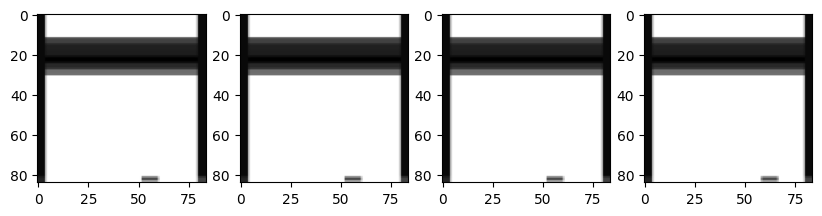

Low value 0.0 - High value 0.5803921818733215


In [4]:
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack, TransformObservation
from utilities.custom_wrappers import ClipReward, AtariCropping, RescaleRange, MaxAndSkipEnv

def generate_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env, skip=4)
    env = ClipReward(env, -1, 1)
    env = AtariCropping(env)
    # gray scale frame
    env = GrayScaleObservation(env, keep_dim=False)
    env = RescaleRange(env)
    # resize frame to 84×84 image
    env = ResizeObservation(env, (84, 84))
    # stack 4 frames (equivalent to what phi does in paper) 
    env = FrameStack(env, num_stack=4)
    
    return env

def require_special_handling(env_name):
    env = generate_env(env_name) 
    env.reset()
    observation, reward, done, info = env.step(env.action_space.sample())
                                               
    return info['lives']>1
    
env = generate_env("BreakoutNoFrameskip-v4") 
env.reset()
observation, reward, done, info = env.step(env.action_space.sample())

print("State shape: ", np.asarray(observation).shape)
print("Info ", info)

# visualize frames in each step 
_, axs = plt.subplots(1, 4, figsize=(10,10))
for i, image in enumerate(observation):
    axs[i].imshow(image, cmap="binary")
plt.show()

# plt.imshow(image, cmap="binary")
# plt.show()

print(f"Low value {np.min(np.asarray(observation))} - High value {np.max(np.asarray(observation))}")

### Function to determine action
Apply $\epsilon$ greedy algorithm to choose action   
* Choose random action at probability $\epsilon$
* Choose optimal action (determined by model) at probability (1-$\epsilon$)

In [5]:
import random

def choose_action(model, state, device, epsilon=0.001):
    if random.random()<=epsilon: #exploration
        return env.action_space.sample()
    else:
        with torch.no_grad():
    #         squeeze to remove last dim of 1 (for gray scaled val) and add 1 dim at first (1 input instead of batch)
            state = torch.Tensor(state).squeeze().unsqueeze(0).to(device)
            # predict
            pred = model(state)
            action = torch.argmax(pred.squeeze()).item()
            return int(action)

### Loss function  
As mentioned in the paper, the function to optimize would be the following
> $$L_i(θ_i) = E_{s,a∼ρ(·)} [(y_i − Q (s, a; θ_i))]^2 $$
> where: $$y_i = E_{s′∼\mathcal{E}} [r + γ max_{a′} Q(s′, a′; θ_{i−1})|s, a]$$

Notation translation:
- θ refers to weights of model, $θ_i$ refers to model (with weights) at iteration i
- $Q (s, a; θ_i)$ (prediction) is Q value at (s, a) estimated by model
- $y_i$ (target function) is calculated using Bellman equation, but future reward (aka Q(s', a')) is (again) estimated by the model

Code translation:
- $Q (s, a; θ_i)$ is calculated by plug in state for model to predict, and get the output at action a (state and action sampled from experience replay)
- $max_{a′} Q(s′, a′; θ_{i−1}$) in $y_i$ is calculated by plug in successor state, then get the max output out of all actions
- loss is square root of $y_i$ (expected Q) - $Q (s, a; θ_i)$ (prediction)

In [6]:
def loss_fn(model, replay_memory, batch_size, discount, target_model=None, device="mps"):
    batch = replay_memory.sample(batch_size)

#     Transpose batch, ref: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Experience(*zip(*batch))
    
#     convert to a single np.array for faster tensor conversion
    state = np.array(batch.state)
    successor = np.array(batch.successor)
            
    # Tensor-ify state, action, reward, successor, done (use torch tensor to have grad)
    state = torch.Tensor(state).squeeze().to(device)
    action = torch.Tensor(batch.action).to(device)
    reward = torch.Tensor(batch.reward).to(device)
    successor = torch.Tensor(successor).squeeze().to(device)
    done = torch.tensor(batch.done, dtype=torch.int32).to(device)

    # use model to get old qs and successor qs
    old_qs = model(state)
    # if target model is provided -> use that to compute successor instead
    successor_qs = model(successor) if target_model is None else target_model(successor) 
        
    # get the list of actions in shape 1xbatch_size, and use it as indices for old_qs
    action = action.unsqueeze(1).type(torch.int64)
    # get predicted qs at action, return tensor of list of batch_size items
    old_qs = old_qs.gather(1, action).squeeze()
    # get max q in successor to estimate future reward
    successor_qs = successor_qs.max(1)[0]
            
    # compute expected qs
    # multiplying (1-done) would result in not adding future reward when at end state (done==1)
    expected_qs = reward + successor_qs*discount*(1-done)
    expected_qs = expected_qs.detach() # shouldnt include this in grad graph
        
    # compute loss, return mean loss of batch 
#     loss = (expected_qs-old_qs).pow(2).mean()
    
    # improvement for stability - use different loss 
    loss_func = nn.HuberLoss()
    loss = loss_func(old_qs, expected_qs)
    
    return loss

### Evaluation 
Evaluate model by let model plays in the env in 10000 steps, and return **average reward** and **predicted Q** value of a <u>held out set of states</u> 

In [7]:
def eval_model(model, env_id, eval_steps=10000, device="mps", special_handling=False):
    env=generate_env(env_id)
    curr_state = env.reset()
    curr_state = np.asarray(curr_state)    
    episode_rewards = [0]
    
    for _ in range(eval_steps):
        action = choose_action(model, curr_state, device, epsilon=0.05)
        
        observation, reward, done, info = env.step(action)
        observation = np.asarray(observation) #convert to np array
        
        episode_rewards[-1]+=reward 
        curr_state = observation
        
        if done:
            # end of episode -> reset env, create new total reward for episode
            curr_state = env.reset()
            curr_state = np.asarray(curr_state)
            episode_rewards.append(0)
            
    # calculate mean episode, exclude last ep as it would be unfinished
    episode_reward = np.array(episode_rewards[:-1] if len(episode_rewards)>1 else episode_rewards)
    return np.mean(episode_reward)

### Parameters

In [8]:
# ------- Set up parameters -------
ENV = "BreakoutNoFrameskip-v4"
LOG_FREQ = 20 #number of EPISODES in-between logging results 
EVAL_FREQ = 50000 #number of STEPS before evaluate model
CHECKPOINT_FREQ = 500000 #number of STEPS before saving model
SAVE_DIR = "BreakoutAgain" #directory to save stuffs
SPECIAL_HANDLING = require_special_handling(ENV) # whether to perform FIRE when loose life (required for Breakout)

# ------ Hyper parameters ---------
LEARNING_RATE = 0.000025
REPLAY_LEN = 100000 # 1000000 in paper, but I still like mah laptop, so no
BATCH_SIZE = 32
EPISODES = 20000
DISCOUNT = 0.99 #aka gamma in Bellman's equation
START_EPSILON= 1
END_EPSILON= 0.1
DECAY_STEPS=1000000 # steps to decay epsilon
USE_TARGET_MODEL=True # whether to have target model or not
UPDATE_TARGET=1000 #steps to run before updating the target model

### Setting up variables before training

In [9]:
# ------- Set up device, check for mps, cuda or cpu -----------
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ------- Set up env ----------------
env = generate_env(ENV)
print(f"Current Atari environment: {ENV}")
print(f"Learning rate: {LEARNING_RATE}")

# ------- Set up model ----------------
model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
target_model = None
if USE_TARGET_MODEL:
    target_model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
    target_model.load_state_dict(model.state_dict())

# ------- Set up optimizer ----------------
# optimizer based on paper
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# recommended (less computational heavy compared to RMSprop)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------- Set up stats tracker ----------------
steps = 0 # no. of steps
highest_reward = 0 # highest evaluation reward
epsilon = 1

# ------- Set up replay buffer ----------------
curr_state = env.reset()
curr_state = np.asarray(curr_state) #convert to np array
replay_memory = ReplayMemory(capacity=REPLAY_LEN)
prev_lives = 0 # keep track of previous life
for i in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    
    # penalize losing life
    reward = np.float64(-1) if (info['lives'] < prev_lives) else reward
    
    observation = np.asarray(observation) #convert to np array
    replay_memory.push(curr_state, action, reward, observation, done)
        
    # update curr state
    curr_state = observation
    prev_lives = info['lives']
    
    if done:
        curr_state = env.reset()
        curr_state = np.asarray(curr_state)
        prev_lives = 0
print(f"Initial length of replay memory: {len(replay_memory)}")

# ------- Set up saving dir ----------------
sub_folders = ["checkpoints", "tensorboard_runs"] # list of subfolders
for sub_folder in sub_folders:
    path = f"{SAVE_DIR}/{sub_folder}/"
    if not os.path.exists(path):
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"{path} created")
        
# ------- Set up Tensorboard --------------
sample_input = replay_memory.sample(32)
#     Transpose 
sample_input = Experience(*zip(*sample_input))
#     convert to a single np.array for faster tensor conversion
sample_state = np.array(sample_input.state)
# Tensor-ify state, action, reward, successor, done
sample_state = torch.Tensor(sample_state).squeeze().to(device)

writer = SummaryWriter(log_dir=f"{SAVE_DIR}/tensorboard_runs/")
writer.add_graph(model, sample_state) # add graph for model

print(f'Start Tensorboard by running this command from project folder: tensorboard --logdir="{SAVE_DIR}/tensorboard_runs"')

Device: mps
Current Atari environment: BreakoutNoFrameskip-v4
Learning rate: 2.5e-05
Initial length of replay memory: 1000
BreakoutAgain/checkpoints/ created
BreakoutAgain/tensorboard_runs/ created
Start Tensorboard by running this command from project folder: tensorboard --logdir="BreakoutAgain/tensorboard_runs"


### Training process

In [ ]:
with tqdm(total=EPISODES, unit="eps") as pbar:
    # main training loop
    for i in range(EPISODES):
        curr_state = env.reset()
        curr_state = np.asarray(curr_state) #convert to np array
        loss_val = 0 # loss value for curr episode
        reward_val = 0 # reward value for curr episode
        prev_lives = 0
        
        while True:
        # ---------- Epsilon decay logic ------------
            # decay over the first million frames then stay at 0.1
            decay = (DECAY_STEPS - steps)/DECAY_STEPS if steps < DECAY_STEPS else 0
            epsilon = END_EPSILON + decay*(START_EPSILON-END_EPSILON)
            
        # ---------- Training steps logic ------------
            # execute action
            action = choose_action(model, curr_state, device, epsilon=epsilon)
            observation, reward, done, info = env.step(action)
            observation = np.asarray(observation) #convert to np array
            
            # encode losing life as ending episode to penalize losing life
            reward = np.float64(-1) if (info['lives'] < prev_lives) else reward
            
            # save observation
            replay_memory.push(curr_state, action, reward, observation, done)
            
            # update curr_state and remaining lives
            curr_state = observation
            prev_lives = info['lives']

            # sample and compute loss
            loss = loss_fn(model, replay_memory, BATCH_SIZE, DISCOUNT, target_model=target_model, device=device)
            loss_item = loss.item()
            
            # zero out gradient before backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ---------- Logging and update various stuffs ------------
            # update target model if available
            if USE_TARGET_MODEL:
                if steps%UPDATE_TARGET:
                    target_model.load_state_dict(model.state_dict())

            # update loss as the max loss during episode
            loss_val = max(loss_item, loss_val)
            # add steps count for epsilon decay
            steps+=1
            # update total reward of episode
            reward_val += reward

            if steps%CHECKPOINT_FREQ==0:
                with open(f"{SAVE_DIR}/checkpoints/{steps}.pt", 'wb') as f:
                    torch.save(model.state_dict(), f)

            if steps%EVAL_FREQ==0:
                pbar.write("------- Evaluating --------")
                # eval steps
                eval_reward = eval_model(model, ENV, eval_steps=10000, device=device, special_handling=SPECIAL_HANDLING)   
#                 eval_rewards.append(eval_reward)
                pbar.write(f"Evaluation reward (average per episode) {eval_reward}")
                pbar.write("---------------------------")
                writer.add_scalar("Eval | Average reward/episode over Steps", eval_reward, steps)
            
                # save best model
                if eval_reward > highest_reward:
                    with open(f"{SAVE_DIR}/checkpoints/best.pt", 'wb') as f:
                        torch.save(model.state_dict(), f)
                highest_reward = max(highest_reward, eval_reward)
                
        # ------ Clean up after each 200 step ------
            del loss
            if steps%200==0:
                gc.collect()

            if done: 
                # finish an episode
                break
                
    # ------ Update training episode stats, use tqdm instead of printing -----
        pbar.update(1)
        pbar.set_description(desc=f"Ep:{i+1}|{steps}steps|Loss:{round(loss_val, 4)}|Reward:{reward_val}")
        
    # ------- Log training loss and training episode rewards for tensorboard
        if i%LOG_FREQ==0:
            writer.add_scalar("Train | Loss over Episode", loss_val, i)
            writer.add_scalar("Train | Reward over Episode", reward_val, i)
            
            
print("FINISH TRAINING PROCESS")
print(f"Finish in {steps} steps, Highest eval reward {highest_reward}")

Ep:279|49953steps|Loss:0.1216|Reward:-4.0:   2%|▍                        | 279/16000 [08:46<8:29:50,  1.95s/eps]

------- Evaluating --------


Ep:279|49953steps|Loss:0.1216|Reward:-4.0:   2%|▍                        | 279/16000 [09:03<8:29:50,  1.95s/eps]

Evaluation reward (average per episode) 0.273972602739726
---------------------------


Ep:566|99962steps|Loss:0.093|Reward:-4.0:   4%|▉                         | 566/16000 [18:41<8:27:23,  1.97s/eps]

------- Evaluating --------


Ep:566|99962steps|Loss:0.093|Reward:-4.0:   4%|▉                         | 566/16000 [18:58<8:27:23,  1.97s/eps]

Evaluation reward (average per episode) 0.33783783783783783
---------------------------


Ep:862|149990steps|Loss:0.0991|Reward:-3.0:   5%|█▎                      | 862/16000 [29:07<8:45:27,  2.08s/eps]

------- Evaluating --------


Ep:862|149990steps|Loss:0.0991|Reward:-3.0:   5%|█▎                      | 862/16000 [29:24<8:45:27,  2.08s/eps]

Evaluation reward (average per episode) 0.08860759493670886
---------------------------


Ep:1148|199950steps|Loss:0.0758|Reward:-3.0:   7%|█▌                    | 1148/16000 [39:36<9:17:40,  2.25s/eps]

------- Evaluating --------


Ep:1148|199950steps|Loss:0.0758|Reward:-3.0:   7%|█▌                    | 1148/16000 [39:54<9:17:40,  2.25s/eps]

Evaluation reward (average per episode) 0.8059701492537313
---------------------------


Ep:1392|249730steps|Loss:0.167|Reward:-2.0:   9%|█▉                    | 1392/16000 [50:08<10:43:31,  2.64s/eps]

------- Evaluating --------


Ep:1393|250005steps|Loss:0.131|Reward:-1.0:   9%|█▉                    | 1393/16000 [50:25<32:29:44,  8.01s/eps]

Evaluation reward (average per episode) 1.5714285714285714
---------------------------


Ep:1617|299945steps|Loss:0.1151|Reward:-3.0:  10%|█▉                 | 1617/16000 [1:00:45<11:25:44,  2.86s/eps]

------- Evaluating --------


Ep:1617|299945steps|Loss:0.1151|Reward:-3.0:  10%|█▉                 | 1617/16000 [1:01:02<11:25:44,  2.86s/eps]

Evaluation reward (average per episode) 3.0
---------------------------


Ep:1830|349764steps|Loss:0.133|Reward:-1.0:  11%|██▎                 | 1830/16000 [1:11:26<11:37:38,  2.95s/eps]

------- Evaluating --------


Ep:1830|349764steps|Loss:0.133|Reward:-1.0:  11%|██▎                 | 1830/16000 [1:11:43<11:37:38,  2.95s/eps]

Evaluation reward (average per episode) 5.32258064516129
---------------------------


Ep:2026|399945steps|Loss:0.0991|Reward:-2.0:  13%|██▍                | 2026/16000 [1:22:13<13:48:52,  3.56s/eps]

------- Evaluating --------


Ep:2026|399945steps|Loss:0.0991|Reward:-2.0:  13%|██▍                | 2026/16000 [1:22:30<13:48:52,  3.56s/eps]

Evaluation reward (average per episode) 5.866666666666666
---------------------------


Ep:2199|449870steps|Loss:0.1071|Reward:0.0:  14%|██▋                 | 2199/16000 [1:33:04<16:43:04,  4.36s/eps]

------- Evaluating --------


Ep:2199|449870steps|Loss:0.1071|Reward:0.0:  14%|██▋                 | 2199/16000 [1:33:21<16:43:04,  4.36s/eps]

Evaluation reward (average per episode) 8.608695652173912
---------------------------


Ep:2355|499970steps|Loss:0.1698|Reward:2.0:  15%|██▉                 | 2355/16000 [1:43:59<16:23:32,  4.32s/eps]

------- Evaluating --------


Ep:2355|499970steps|Loss:0.1698|Reward:2.0:  15%|██▉                 | 2355/16000 [1:44:16<16:23:32,  4.32s/eps]

Evaluation reward (average per episode) 8.863636363636363
---------------------------


Ep:2498|549640steps|Loss:0.1097|Reward:0.0:  16%|███                 | 2498/16000 [1:55:00<18:08:57,  4.84s/eps]

------- Evaluating --------


Ep:2498|549640steps|Loss:0.1097|Reward:0.0:  16%|███                 | 2498/16000 [1:55:17<18:08:57,  4.84s/eps]

Evaluation reward (average per episode) 12.588235294117647
---------------------------


Ep:2622|599682steps|Loss:0.0838|Reward:-1.0:  16%|███                | 2622/16000 [2:06:08<19:00:41,  5.12s/eps]

------- Evaluating --------


Ep:2622|599682steps|Loss:0.0838|Reward:-1.0:  16%|███                | 2622/16000 [2:06:25<19:00:41,  5.12s/eps]

Evaluation reward (average per episode) 14.2
---------------------------


Ep:2732|649564steps|Loss:0.0927|Reward:3.0:  17%|███▍                | 2732/16000 [2:17:22<22:28:10,  6.10s/eps]

------- Evaluating --------


Ep:2732|649564steps|Loss:0.0927|Reward:3.0:  17%|███▍                | 2732/16000 [2:17:39<22:28:10,  6.10s/eps]

Evaluation reward (average per episode) 12.529411764705882
---------------------------


Ep:2835|699459steps|Loss:0.118|Reward:8.0:  18%|███▋                 | 2835/16000 [2:28:42<23:15:46,  6.36s/eps]

------- Evaluating --------


Ep:2836|700005steps|Loss:0.0863|Reward:6.0:  18%|███▌                | 2836/16000 [2:28:59<42:42:11, 11.68s/eps]

Evaluation reward (average per episode) 16.214285714285715
---------------------------


Ep:2932|749570steps|Loss:0.1033|Reward:11.0:  18%|███▍               | 2932/16000 [2:40:08<26:02:32,  7.17s/eps]

------- Evaluating --------


Ep:2932|749570steps|Loss:0.1033|Reward:11.0:  18%|███▍               | 2932/16000 [2:40:25<26:02:32,  7.17s/eps]

Evaluation reward (average per episode) 14.0
---------------------------


Ep:3026|799995steps|Loss:0.102|Reward:7.0:  19%|███▉                 | 3026/16000 [2:51:42<24:30:03,  6.80s/eps]

------- Evaluating --------


Ep:3026|799995steps|Loss:0.102|Reward:7.0:  19%|███▉                 | 3026/16000 [2:51:59<24:30:03,  6.80s/eps]

Evaluation reward (average per episode) 16.785714285714285
---------------------------


Ep:3108|849983steps|Loss:0.1395|Reward:3.0:  19%|███▉                | 3108/16000 [3:03:25<26:03:29,  7.28s/eps]

------- Evaluating --------


Ep:3108|849983steps|Loss:0.1395|Reward:3.0:  19%|███▉                | 3108/16000 [3:03:42<26:03:29,  7.28s/eps]

Evaluation reward (average per episode) 18.5
---------------------------


Ep:3182|899223steps|Loss:0.0765|Reward:8.0:  20%|███▉                | 3182/16000 [3:15:16<31:47:28,  8.93s/eps]

------- Evaluating --------


Ep:3182|899223steps|Loss:0.0765|Reward:8.0:  20%|███▉                | 3182/16000 [3:15:33<31:47:28,  8.93s/eps]

Evaluation reward (average per episode) 20.90909090909091
---------------------------


Ep:3248|949744steps|Loss:0.1031|Reward:13.0:  20%|███▊               | 3248/16000 [3:27:12<39:06:08, 11.04s/eps]

------- Evaluating --------


Ep:3248|949744steps|Loss:0.1031|Reward:13.0:  20%|███▊               | 3248/16000 [3:27:29<39:06:08, 11.04s/eps]

Evaluation reward (average per episode) 23.09090909090909
---------------------------


Ep:3313|999295steps|Loss:0.1518|Reward:15.0:  21%|███▉               | 3313/16000 [3:39:21<38:17:41, 10.87s/eps]

------- Evaluating --------


Ep:3313|999295steps|Loss:0.1518|Reward:15.0:  21%|███▉               | 3313/16000 [3:39:39<38:17:41, 10.87s/eps]

Evaluation reward (average per episode) 20.333333333333332
---------------------------


Ep:3372|1049973steps|Loss:0.1306|Reward:26.0:  21%|███▊              | 3372/16000 [3:51:29<51:44:15, 14.75s/eps]

------- Evaluating --------


Ep:3372|1049973steps|Loss:0.1306|Reward:26.0:  21%|███▊              | 3372/16000 [3:51:46<51:44:15, 14.75s/eps]

Evaluation reward (average per episode) 24.4
---------------------------


Ep:3429|1099805steps|Loss:0.1205|Reward:19.0:  21%|███▊              | 3429/16000 [4:03:49<46:53:21, 13.43s/eps]

------- Evaluating --------


Ep:3429|1099805steps|Loss:0.1205|Reward:19.0:  21%|███▊              | 3429/16000 [4:04:07<46:53:21, 13.43s/eps]

Evaluation reward (average per episode) 20.545454545454547
---------------------------


Ep:3483|1149079steps|Loss:0.0969|Reward:13.0:  22%|███▉              | 3483/16000 [4:16:10<44:39:59, 12.85s/eps]

------- Evaluating --------


Ep:3484|1150000steps|Loss:0.1019|Reward:16.0:  22%|███▉              | 3484/16000 [4:16:27<62:45:21, 18.05s/eps]

Evaluation reward (average per episode) 24.88888888888889
---------------------------


Ep:3539|1199757steps|Loss:0.1159|Reward:23.0:  22%|███▉              | 3539/16000 [4:28:31<46:29:27, 13.43s/eps]

------- Evaluating --------


Ep:3539|1199757steps|Loss:0.1159|Reward:23.0:  22%|███▉              | 3539/16000 [4:28:48<46:29:27, 13.43s/eps]

Evaluation reward (average per episode) 25.1
---------------------------


Ep:3596|1249883steps|Loss:0.1073|Reward:16.0:  22%|████              | 3596/16000 [4:40:52<39:58:49, 11.60s/eps]

------- Evaluating --------


Ep:3596|1249883steps|Loss:0.1073|Reward:16.0:  22%|████              | 3596/16000 [4:41:09<39:58:49, 11.60s/eps]

Evaluation reward (average per episode) 27.22222222222222
---------------------------


Ep:3647|1299335steps|Loss:0.1145|Reward:19.0:  23%|████              | 3647/16000 [4:53:14<52:15:40, 15.23s/eps]

------- Evaluating --------


Ep:3647|1299335steps|Loss:0.1145|Reward:19.0:  23%|████              | 3647/16000 [4:53:31<52:15:40, 15.23s/eps]

Evaluation reward (average per episode) 25.333333333333332
---------------------------


Ep:3700|1349716steps|Loss:0.1298|Reward:22.0:  23%|████▏             | 3700/16000 [5:05:36<48:13:55, 14.12s/eps]

------- Evaluating --------


Ep:3700|1349716steps|Loss:0.1298|Reward:22.0:  23%|████▏             | 3700/16000 [5:05:53<48:13:55, 14.12s/eps]

Evaluation reward (average per episode) 26.77777777777778
---------------------------


Ep:3751|1399503steps|Loss:0.0729|Reward:3.0:  23%|████▍              | 3751/16000 [5:17:59<42:15:24, 12.42s/eps]

------- Evaluating --------


Ep:3751|1399503steps|Loss:0.0729|Reward:3.0:  23%|████▍              | 3751/16000 [5:18:15<42:15:24, 12.42s/eps]

Evaluation reward (average per episode) 25.2
---------------------------


Ep:3803|1449324steps|Loss:0.111|Reward:15.0:  24%|████▌              | 3803/16000 [5:30:21<41:17:25, 12.19s/eps]

------- Evaluating --------


Ep:3803|1449324steps|Loss:0.111|Reward:15.0:  24%|████▌              | 3803/16000 [5:30:38<41:17:25, 12.19s/eps]

Evaluation reward (average per episode) 28.22222222222222
---------------------------


Ep:3855|1499282steps|Loss:0.09|Reward:11.0:  24%|████▊               | 3855/16000 [5:42:45<44:09:58, 13.09s/eps]

------- Evaluating --------


Ep:3855|1499282steps|Loss:0.09|Reward:11.0:  24%|████▊               | 3855/16000 [5:43:03<44:09:58, 13.09s/eps]

Evaluation reward (average per episode) 25.8
---------------------------


Ep:3905|1549992steps|Loss:0.1461|Reward:21.0:  24%|████▍             | 3905/16000 [5:55:10<52:55:56, 15.75s/eps]

------- Evaluating --------


Ep:3905|1549992steps|Loss:0.1461|Reward:21.0:  24%|████▍             | 3905/16000 [5:55:27<52:55:56, 15.75s/eps]

Evaluation reward (average per episode) 27.11111111111111
---------------------------


Ep:3957|1599553steps|Loss:0.2157|Reward:15.0:  25%|████▍             | 3957/16000 [6:07:33<40:44:19, 12.18s/eps]

------- Evaluating --------


Ep:3957|1599553steps|Loss:0.2157|Reward:15.0:  25%|████▍             | 3957/16000 [6:07:50<40:44:19, 12.18s/eps]

Evaluation reward (average per episode) 30.5
---------------------------


Ep:4005|1649259steps|Loss:0.1306|Reward:18.0:  25%|████▌             | 4005/16000 [6:19:59<45:43:29, 13.72s/eps]

------- Evaluating --------


Ep:4005|1649259steps|Loss:0.1306|Reward:18.0:  25%|████▌             | 4005/16000 [6:20:16<45:43:29, 13.72s/eps]

Evaluation reward (average per episode) 27.333333333333332
---------------------------


Ep:4057|1699742steps|Loss:0.1559|Reward:24.0:  25%|████▌             | 4057/16000 [6:32:24<51:55:01, 15.65s/eps]

------- Evaluating --------


Ep:4057|1699742steps|Loss:0.1559|Reward:24.0:  25%|████▌             | 4057/16000 [6:32:41<51:55:01, 15.65s/eps]

Evaluation reward (average per episode) 23.636363636363637
---------------------------


Ep:4108|1749493steps|Loss:0.1365|Reward:23.0:  26%|████▌             | 4108/16000 [6:44:51<51:41:22, 15.65s/eps]

------- Evaluating --------


Ep:4108|1749493steps|Loss:0.1365|Reward:23.0:  26%|████▌             | 4108/16000 [6:45:08<51:41:22, 15.65s/eps]

Evaluation reward (average per episode) 26.333333333333332
---------------------------


Ep:4159|1799309steps|Loss:0.1737|Reward:19.0:  26%|████▋             | 4159/16000 [6:57:16<47:21:01, 14.40s/eps]

------- Evaluating --------


Ep:4159|1799309steps|Loss:0.1737|Reward:19.0:  26%|████▋             | 4159/16000 [6:57:33<47:21:01, 14.40s/eps]

Evaluation reward (average per episode) 28.77777777777778
---------------------------


Ep:4216|1849292steps|Loss:0.1241|Reward:27.0:  26%|████▋             | 4216/16000 [7:09:29<46:51:00, 14.31s/eps]

------- Evaluating --------


Ep:4216|1849292steps|Loss:0.1241|Reward:27.0:  26%|████▋             | 4216/16000 [7:09:46<46:51:00, 14.31s/eps]

Evaluation reward (average per episode) 30.5
---------------------------


Ep:4272|1899542steps|Loss:1.6198|Reward:16.0:  27%|████▊             | 4272/16000 [7:21:55<44:33:25, 13.68s/eps]

------- Evaluating --------


Ep:4272|1899542steps|Loss:1.6198|Reward:16.0:  27%|████▊             | 4272/16000 [7:22:12<44:33:25, 13.68s/eps]

Evaluation reward (average per episode) 26.22222222222222
---------------------------


Ep:4328|1949428steps|Loss:0.1564|Reward:17.0:  27%|████▊             | 4328/16000 [7:34:23<42:56:10, 13.24s/eps]

------- Evaluating --------


Ep:4328|1949428steps|Loss:0.1564|Reward:17.0:  27%|████▊             | 4328/16000 [7:34:40<42:56:10, 13.24s/eps]

Evaluation reward (average per episode) 27.4
---------------------------


Ep:4380|1999368steps|Loss:0.1382|Reward:29.0:  27%|████▉             | 4380/16000 [7:46:55<51:53:32, 16.08s/eps]

------- Evaluating --------


Ep:4380|1999368steps|Loss:0.1382|Reward:29.0:  27%|████▉             | 4380/16000 [7:47:12<51:53:32, 16.08s/eps]

Evaluation reward (average per episode) 29.5
---------------------------


Ep:4434|2048892steps|Loss:0.14|Reward:24.0:  28%|█████▌              | 4434/16000 [7:59:25<47:35:28, 14.81s/eps]

------- Evaluating --------


Ep:4434|2048892steps|Loss:0.14|Reward:24.0:  28%|█████▌              | 4434/16000 [7:59:42<47:35:28, 14.81s/eps]

Evaluation reward (average per episode) 25.9
---------------------------


Ep:4486|2099257steps|Loss:0.142|Reward:30.0:  28%|█████▎             | 4486/16000 [8:11:55<56:55:21, 17.80s/eps]

------- Evaluating --------


Ep:4486|2099257steps|Loss:0.142|Reward:30.0:  28%|█████▎             | 4486/16000 [8:12:12<56:55:21, 17.80s/eps]

Evaluation reward (average per episode) 24.77777777777778
---------------------------


Ep:4539|2149519steps|Loss:0.1418|Reward:26.0:  28%|█████             | 4539/16000 [8:24:26<43:07:54, 13.55s/eps]

------- Evaluating --------


Ep:4539|2149519steps|Loss:0.1418|Reward:26.0:  28%|█████             | 4539/16000 [8:24:43<43:07:54, 13.55s/eps]

Evaluation reward (average per episode) 26.444444444444443
---------------------------


Ep:4591|2199210steps|Loss:0.1216|Reward:19.0:  29%|█████▏            | 4591/16000 [8:36:57<40:11:56, 12.68s/eps]

------- Evaluating --------


Ep:4591|2199210steps|Loss:0.1216|Reward:19.0:  29%|█████▏            | 4591/16000 [8:37:14<40:11:56, 12.68s/eps]

Evaluation reward (average per episode) 25.0
---------------------------


Ep:4621|2226461steps|Loss:0.1325|Reward:13.0:  29%|█████▏            | 4621/16000 [8:43:42<41:33:29, 13.15s/eps]

In [24]:
# close tensorboard if terminate early
writer.close()

### Save model

In [25]:
with open('breakout.pt', 'wb') as f:
    torch.save(model.state_dict(), f)